<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Давайте-посмоотрим-на-данные" data-toc-modified-id="Давайте-посмоотрим-на-данные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Давайте посмоотрим на данные</a></span><ul class="toc-item"><li><span><a href="#Загружаем-данные" data-toc-modified-id="Загружаем-данные-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загружаем данные</a></span></li><li><span><a href="#Модифицируем-данные" data-toc-modified-id="Модифицируем-данные-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модифицируем данные</a></span></li><li><span><a href="#Вводим-новое-признаковое-описание-треков" data-toc-modified-id="Вводим-новое-признаковое-описание-треков-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вводим новое признаковое описание треков</a></span></li></ul></li><li><span><a href="#Обучаем-модели" data-toc-modified-id="Обучаем-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучаем модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Постановка задачи

В задаче предложено по данным акселерометра смартфона из  датасета  http://www.cis.fordham.edu/wisdm/dataset.php определить один из 6 типов движения человека

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

In [2]:
DATA_PATH = './data/Accel_data/data_raw.txt'

## Давайте посмоотрим на данные
### Загружаем данные

In [3]:
dictionary = {'user':[], 'activity':[], 'time':[], 'x_acc':[],'y_acc':[],'z_acc':[] }

def parse_line( line):
    user = activity = time = x_acc = y_acc = z_acc = None
    try:
        string = line.strip(';\n').split(',')
        user = int( string[ 0 ])
        activity = string[ 1 ]
        time = int( string[ 2 ])
        x_acc = float( string[ 3 ])
        y_acc = float( string[ 4 ])
        z_acc = float( string[ 5 ])
    except:
        print( 'dropped', line)
    else:
        if time and time > 1e-9:
            dictionary['user'].append(user)
            dictionary['activity'].append( activity)
            dictionary['time'].append( time)
            dictionary['x_acc'].append( x_acc)
            dictionary['y_acc'].append( y_acc)
            dictionary['z_acc'].append( z_acc)

with open (DATA_PATH, "r") as file:
    for line in file.readlines():
        for sline in line.split(';'):
            if sline.strip():
                parse_line( sline)
row_data = pd.DataFrame(data = dictionary)
row_data = row_data.sort_values(by = ['user', 'time'])

row_data.head(10)

dropped 11,Walking,1867172313000,4.4,4.4,



,user,activity,time,x_acc,y_acc,z_acc
929120,1,Walking,4991922345000,0.69,10.80,-2.03
929121,1,Walking,4991972333000,6.85,7.44,-0.50
929122,1,Walking,4992022351000,0.93,5.63,-0.50
929123,1,Walking,4992072339000,-2.11,5.01,-0.69
929124,1,Walking,4992122358000,-4.59,4.29,-1.95
929125,1,Walking,4992172376000,12.41,11.18,7.82
929126,1,Walking,4992222333000,17.27,11.60,5.94
929127,1,Walking,4992272321000,1.42,8.43,-5.28
929128,1,Walking,4992322339000,-2.68,15.89,-0.38
929129,1,Walking,4992372327000,-1.38,9.92,-1.99


In [4]:
print( row_data.size//len(row_data.columns))
users = set(row_data.user)
activities = set(row_data.activity)
print(users)
print(activities)

1085363
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}
{'Jogging', 'Downstairs', 'Walking', 'Upstairs', 'Sitting', 'Standing'}


# [3]


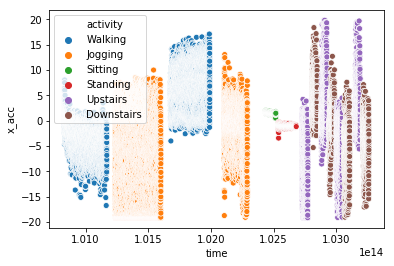

In [5]:
user = random.sample(users, 1)
sns.scatterplot(x="time", y="x_acc", hue="activity",data=row_data[row_data.user == user])
print('#', user)
plt.show()

### Модифицируем данные
Номер пользователя является избыточной информацией, вместо нее введем номер трека, для каждого типа движения


In [6]:
row_cols = ['user', 'activity', 'time', 'x_acc','y_acc','z_acc']
cols = ['track', 'activity', 'time', 'x_acc', 'y_acc', 'z_acc', 'avx_acc', 'avy_acc', 'avz_acc', 'g2']

user = -1
activity = None
track = 0
startpoint = 0
last = None
data_dict = {key:[] for key in cols}
traks_by_type = {key:[] for key in activities}
i = 0 # index inside track
next_track = False
NUM_OF_SAMPLES = 100 # numper of samples for average 5 seconds in real time

ax_arr = []
ay_arr = []
az_arr = []

for row in row_data.values:
    delta = row[2] - last if ( last is not None) else None
    if user != row[0] or activity != row[1] or (delta and delta > 0.25*10**9):
        if next_track:
            track += 1
        activity = row[1]
        user = row[0]
        startpoint = row[2]
        last = None
        traks_by_type[activity].append(track)
        i = 0
        next_track = False
    if i > NUM_OF_SAMPLES:
        next_track = True
        data_dict['track'].append(track)
        data_dict['activity'].append(activity)
        data_dict['time'].append((row[2] - startpoint)/1e9)
        data_dict['x_acc'].append(row[3])
        data_dict['y_acc'].append(row[4])
        data_dict['z_acc'].append(row[5])
        ax = np.average(ax_arr[-NUM_OF_SAMPLES:])
        ay = np.average(ay_arr[-NUM_OF_SAMPLES:])
        az = np.average(az_arr[-NUM_OF_SAMPLES:])
        data_dict['avx_acc'].append(ax)
        data_dict['avy_acc'].append(ay)
        data_dict['avz_acc'].append(az)
        data_dict['g2'].append(ax**2 + ay**2 + az**2)
    last = row[2]
    ax_arr.append(row[3])
    ay_arr.append(row[4])
    az_arr.append(row[5])
    i += 1
data = pd.DataFrame(data=data_dict)

data.head(10)

,track,activity,time,x_acc,y_acc,z_acc,avx_acc,avy_acc,avz_acc,g2
0,0,Walking,5.069977,12.57,10.65,3.87,3.7657,9.8097,-0.4454,110.609092
1,0,Walking,5.119965,6.74,15.51,-0.38,3.8229,9.8418,-0.4017,111.636955
2,0,Walking,5.169953,2.91,19.50,-4.63,3.8810,9.9406,-0.4005,114.038090
3,0,Walking,5.220002,-0.11,15.02,-5.94,3.9312,10.0855,-0.4399,117.365156
4,0,Walking,5.269989,4.67,5.18,-0.76,3.9760,10.1928,-0.4798,119.931956
5,0,Walking,5.319977,0.57,3.53,-1.33,3.8986,10.1328,-0.5656,118.192621
6,0,Walking,5.369996,-2.83,2.79,-3.02,3.7316,10.0521,-0.6383,115.376980
7,0,Walking,5.419953,-9.58,5.13,-4.25,3.6891,9.9957,-0.6157,113.902564
8,0,Walking,5.470002,9.04,9.77,12.11,3.6201,9.8881,-0.6544,111.307885
9,0,Walking,5.519989,19.04,16.02,3.11,3.7243,9.8866,-0.5134,111.878850


In [7]:
num_tracks = track
for key, value in traks_by_type.items():
    print('%s: %i'%(key, len(value)))

Jogging: 1779
Downstairs: 193
Walking: 255
Upstairs: 178
Sitting: 28
Standing: 25


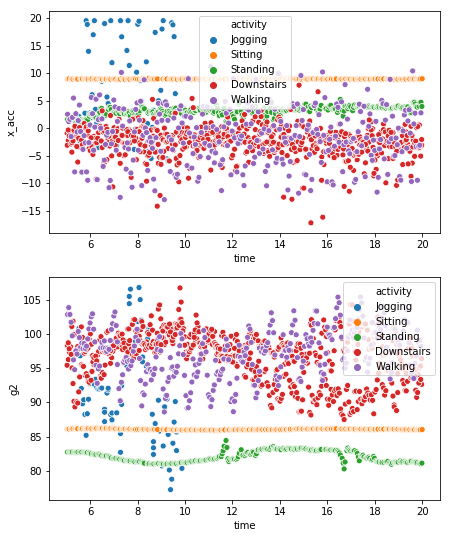

In [8]:
tr_ids = [random.choice(x) for x in  traks_by_type.values()]

f, axes = plt.subplots(2, 1, figsize=(7, 9))

sns.scatterplot(x="time", y="x_acc", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 20)],
                ax=axes[0])

sns.scatterplot(x="time", y="g2", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 20)],
                ax=axes[1])

plt.show()

В описании датасета сказано, что данныйе включают ускорение, земного притяжения равное 10, поэтому перейдем к призноковуму описанию: ускорение к "центру земли| перпенддикулярное ускорение 

In [9]:
data['vert_acc'] = (data.avx_acc * data.x_acc + data.avy_acc * data.y_acc + data.avz_acc * data.z_acc) / data.g2 # (g a)/g^2
data['hor_acc'] = ((data.x_acc**2 + data.y_acc**2 + data.z_acc**2) / data.g2 - data.vert_acc**2)**0.5
data.head(10)

,track,activity,time,x_acc,y_acc,z_acc,avx_acc,avy_acc,avz_acc,g2,vert_acc,hor_acc
0,0,Walking,5.069977,12.57,10.65,3.87,3.7657,9.8097,-0.4454,110.609092,1.356891,0.864977
1,0,Walking,5.119965,6.74,15.51,-0.38,3.8229,9.8418,-0.4017,111.636955,1.599518,0.067834
2,0,Walking,5.169953,2.91,19.50,-4.63,3.8810,9.9406,-0.4005,114.038090,1.815093,0.549624
3,0,Walking,5.220002,-0.11,15.02,-5.94,3.9312,10.0855,-0.4399,117.365156,1.309288,0.713238
4,0,Walking,5.269989,4.67,5.18,-0.76,3.9760,10.1928,-0.4798,119.931956,0.598100,0.229493
5,0,Walking,5.319977,0.57,3.53,-1.33,3.8986,10.1328,-0.5656,118.192621,0.327797,0.125271
6,0,Walking,5.369996,-2.83,2.79,-3.02,3.7316,10.0521,-0.6383,115.376980,0.168254,0.433153
7,0,Walking,5.419953,-9.58,5.13,-4.25,3.6891,9.9957,-0.6157,113.902564,0.162886,1.081129
8,0,Walking,5.470002,9.04,9.77,12.11,3.6201,9.8881,-0.6544,111.307885,1.090737,1.311327
9,0,Walking,5.519989,19.04,16.02,3.11,3.7243,9.8866,-0.5134,111.878850,2.035213,1.215967


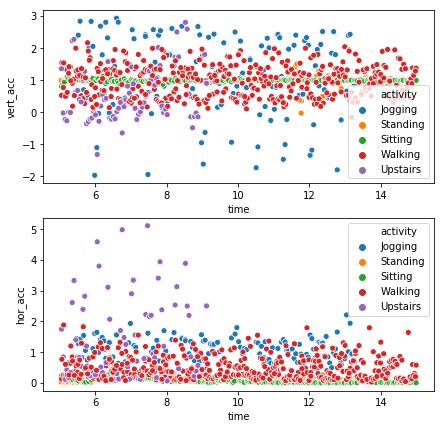

In [10]:
tr_ids = [random.choice(x) for x in  traks_by_type.values()]

f, axes = plt.subplots(2, 1, figsize=(7, 7))

sns.scatterplot(x="time", y="vert_acc", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 15)],
                ax=axes[0])

sns.scatterplot(x="time", y="hor_acc", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 15)],
                ax=axes[1])

plt.show()

Перейдем к более коротким трекам (10 секунд) - для увеличения числа обектов в выборке, а так же сменим также сменим признаковое описание трека - амплтуда, среднее, спектральные характеристики

In [11]:
#AFA - max Autitude,its Frequency and Average autitude
def getFFT_MFA(time,signal, plot = 0,color = 'm', num_columns = 20):
    sigma = 5
    def G(x):
        return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-x**2/2/sigma**2)
    gauss_kernel = [G(x - 3*sigma) for x in range(6*sigma+1)]
    #type_act_for_rand = "Downstairs"
    #color_for_rand = "red"
    #random_track_num = random.choice(traks_by_type[type_act_for_rand])
    #random_track = data[data.track == random_track_num]
  
    #FFT
    FFT = np.fft.fft(signal)
    freq = np.fft.fftfreq(time.shape[-1])
    #Sort
    pack = list(zip(freq, FFT.real))
    pack.sort()
    freq, FFT = zip(*pack)
    #Gaussian_blur
    freq_lenght = -(len(freq)//2 +len(freq)//20) +(len(freq) -10)
    time_FFT = [0.0]*(freq_lenght- 6*sigma)
    time_freq = [0.0]*(freq_lenght - 6 *sigma)

    for i in range (3*sigma,freq_lenght-3*sigma):
        for j in range (6*sigma+1):
            time_FFT[i- 3*sigma] = time_FFT[i - 3*sigma]+FFT[ len(freq)//2+ len(freq)//20 + i-3*sigma + j]**2*gauss_kernel[j]
        time_freq[i- 3*sigma]  = freq[len(freq)//2+len(freq)//20+ i]
    freq = time_freq
    FFT = time_FFT
       
    average_autitude = np.mean(FFT)
    index_max =  np.argmax(FFT)
    autitude_max = FFT[index_max]
    frequency_max = freq[index_max]
    hist = [0]*num_columns
    delta_x = (freq[-1] - freq[0]) / num_columns
    for i in range(1, len(freq)):
        x = freq[i] - freq[0]
        dx = freq[i] - freq[i-1]
        F = (FFT[i] + FFT[i-1] )/2
        #print(x,delta_x, int(x/delta_x))
        hist[min([ int(x/delta_x), num_columns -1])] += F*dx/delta_x
        
    #plot
    if (plot):
        plt.plot(freq, FFT,color = color)
        plt.plot(freq, [hist[min( int((x - freq[0])/delta_x), num_columns -1)] for x in freq],
                                 color = 'blue')
        plt.show() 
    return autitude_max,frequency_max,average_autitude, hist
    
    

### Вводим новое признаковое описание треков

пространственно-временные

- **vert_acc_av** - среднее ускорение по вертикальной оси

- **vert_acc_std** - разброс ускорения по вертикальной оси

- **hor_acc_av** - среднее ускорение по горизонтальной оси

- **hor_acc_std** - разброс ускорения по горизонтальной оси

и спектральные

- **vert_sp_max** - квадрат амплитуды максимального пика на сглаженном спектре ускорения по вертикальной оси

- **vert_sp_fr** - частота максимального пика на сглаженном спектре ускорения по вертикальной оси

- **vert_sp_fr** - средний квадрат амплитуды сглаженного спектра ускорения по вертикальной оси

- **hor_sp_max** - квадрат амплитуды максимального пика на сглаженном спектре ускорения по горизонтальной оси

- **hor_sp_fr** - частота максимального пика на сглаженном спектре ускорения по горизонтальной оси

- **hor_sp_fr** - средний квадрат амплитуды сглаженного спектра ускорения по горизонтальной оси


In [12]:
hist_size = 20
data_short = data.drop(columns = ['x_acc','y_acc','z_acc', 'avx_acc', 'avy_acc', 'avz_acc', 'g2'])
new_columns = ['vert_acc_av', 'hor_acc_av', 'vert_acc_std', 'hor_acc_std', 'hor_sp_max',
               'hor_sp_fr','vert_sp_max', 'vert_sp_fr', 'hor_sp_av', 'vert_sp_av', 
               *['hist_hor'+str(i) for i in range(hist_size)],
               *['hist_vert'+str(i) for i in range(hist_size)], 'label']

new_data_dict = {key:[] for key in new_columns}
tracks_by_label = {key:[] for key in activities}
SEMP_NUM = 300 
ind = 0

for track in range(num_tracks):
    track_data = data_short[data_short.track == track].drop(columns=['track'])
    for i in range(len(track_data)//SEMP_NUM):
        sub_track_data = track_data[i*SEMP_NUM:(i + 1)*SEMP_NUM]
        new_data_dict['vert_acc_av'].append(sub_track_data.vert_acc.mean())
        new_data_dict['vert_acc_std'].append(sub_track_data.vert_acc.std())
        new_data_dict['hor_acc_av'].append(sub_track_data.hor_acc.mean())
        new_data_dict['hor_acc_std'].append(sub_track_data.hor_acc.std())
        ma, fr, av, hist = getFFT_MFA(sub_track_data.time.values,
                                      sub_track_data.hor_acc.values, num_columns = hist_size)
        new_data_dict['hor_sp_max'].append(ma)
        new_data_dict['hor_sp_fr'].append(fr)
        new_data_dict['hor_sp_av'].append(av)
        for s in range(hist_size):
            new_data_dict['hist_hor'+str(s)].append(hist[s])
            
            
        ma, fr, av,hist = getFFT_MFA(sub_track_data.time.values,
                                     sub_track_data.vert_acc.values, num_columns = hist_size)
        new_data_dict['vert_sp_max'].append(ma)
        new_data_dict['vert_sp_fr'].append(fr)
        new_data_dict['vert_sp_av'].append(av)
        for s in range(hist_size):
            new_data_dict['hist_vert'+str(s)].append(hist[s])
        new_data_dict['label'].append(sub_track_data.activity.values[0])

new_data = pd.DataFrame(data = new_data_dict)

example of Fourier Transform

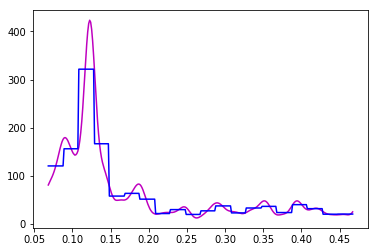

657 Downstairs


In [13]:
track_num = 0
while True:
    track_num  = random.randint(0, num_tracks - 1)
    track_data = data_short[data_short.track == track_num].drop(columns=['track'])
    if len(track_data.time.values) > 300:
        break
#print(new_data.iloc[ random.randint(0,new_data.shape[0] -1)])
getFFT_MFA(track_data.time.values , track_data.vert_acc.values, plot = 1 )
print(track_num, track_data.activity.values[0])

Посмотрим на попарные распределения признаков, и наиболее интересные распределения отдельно взятых

/home/anton/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


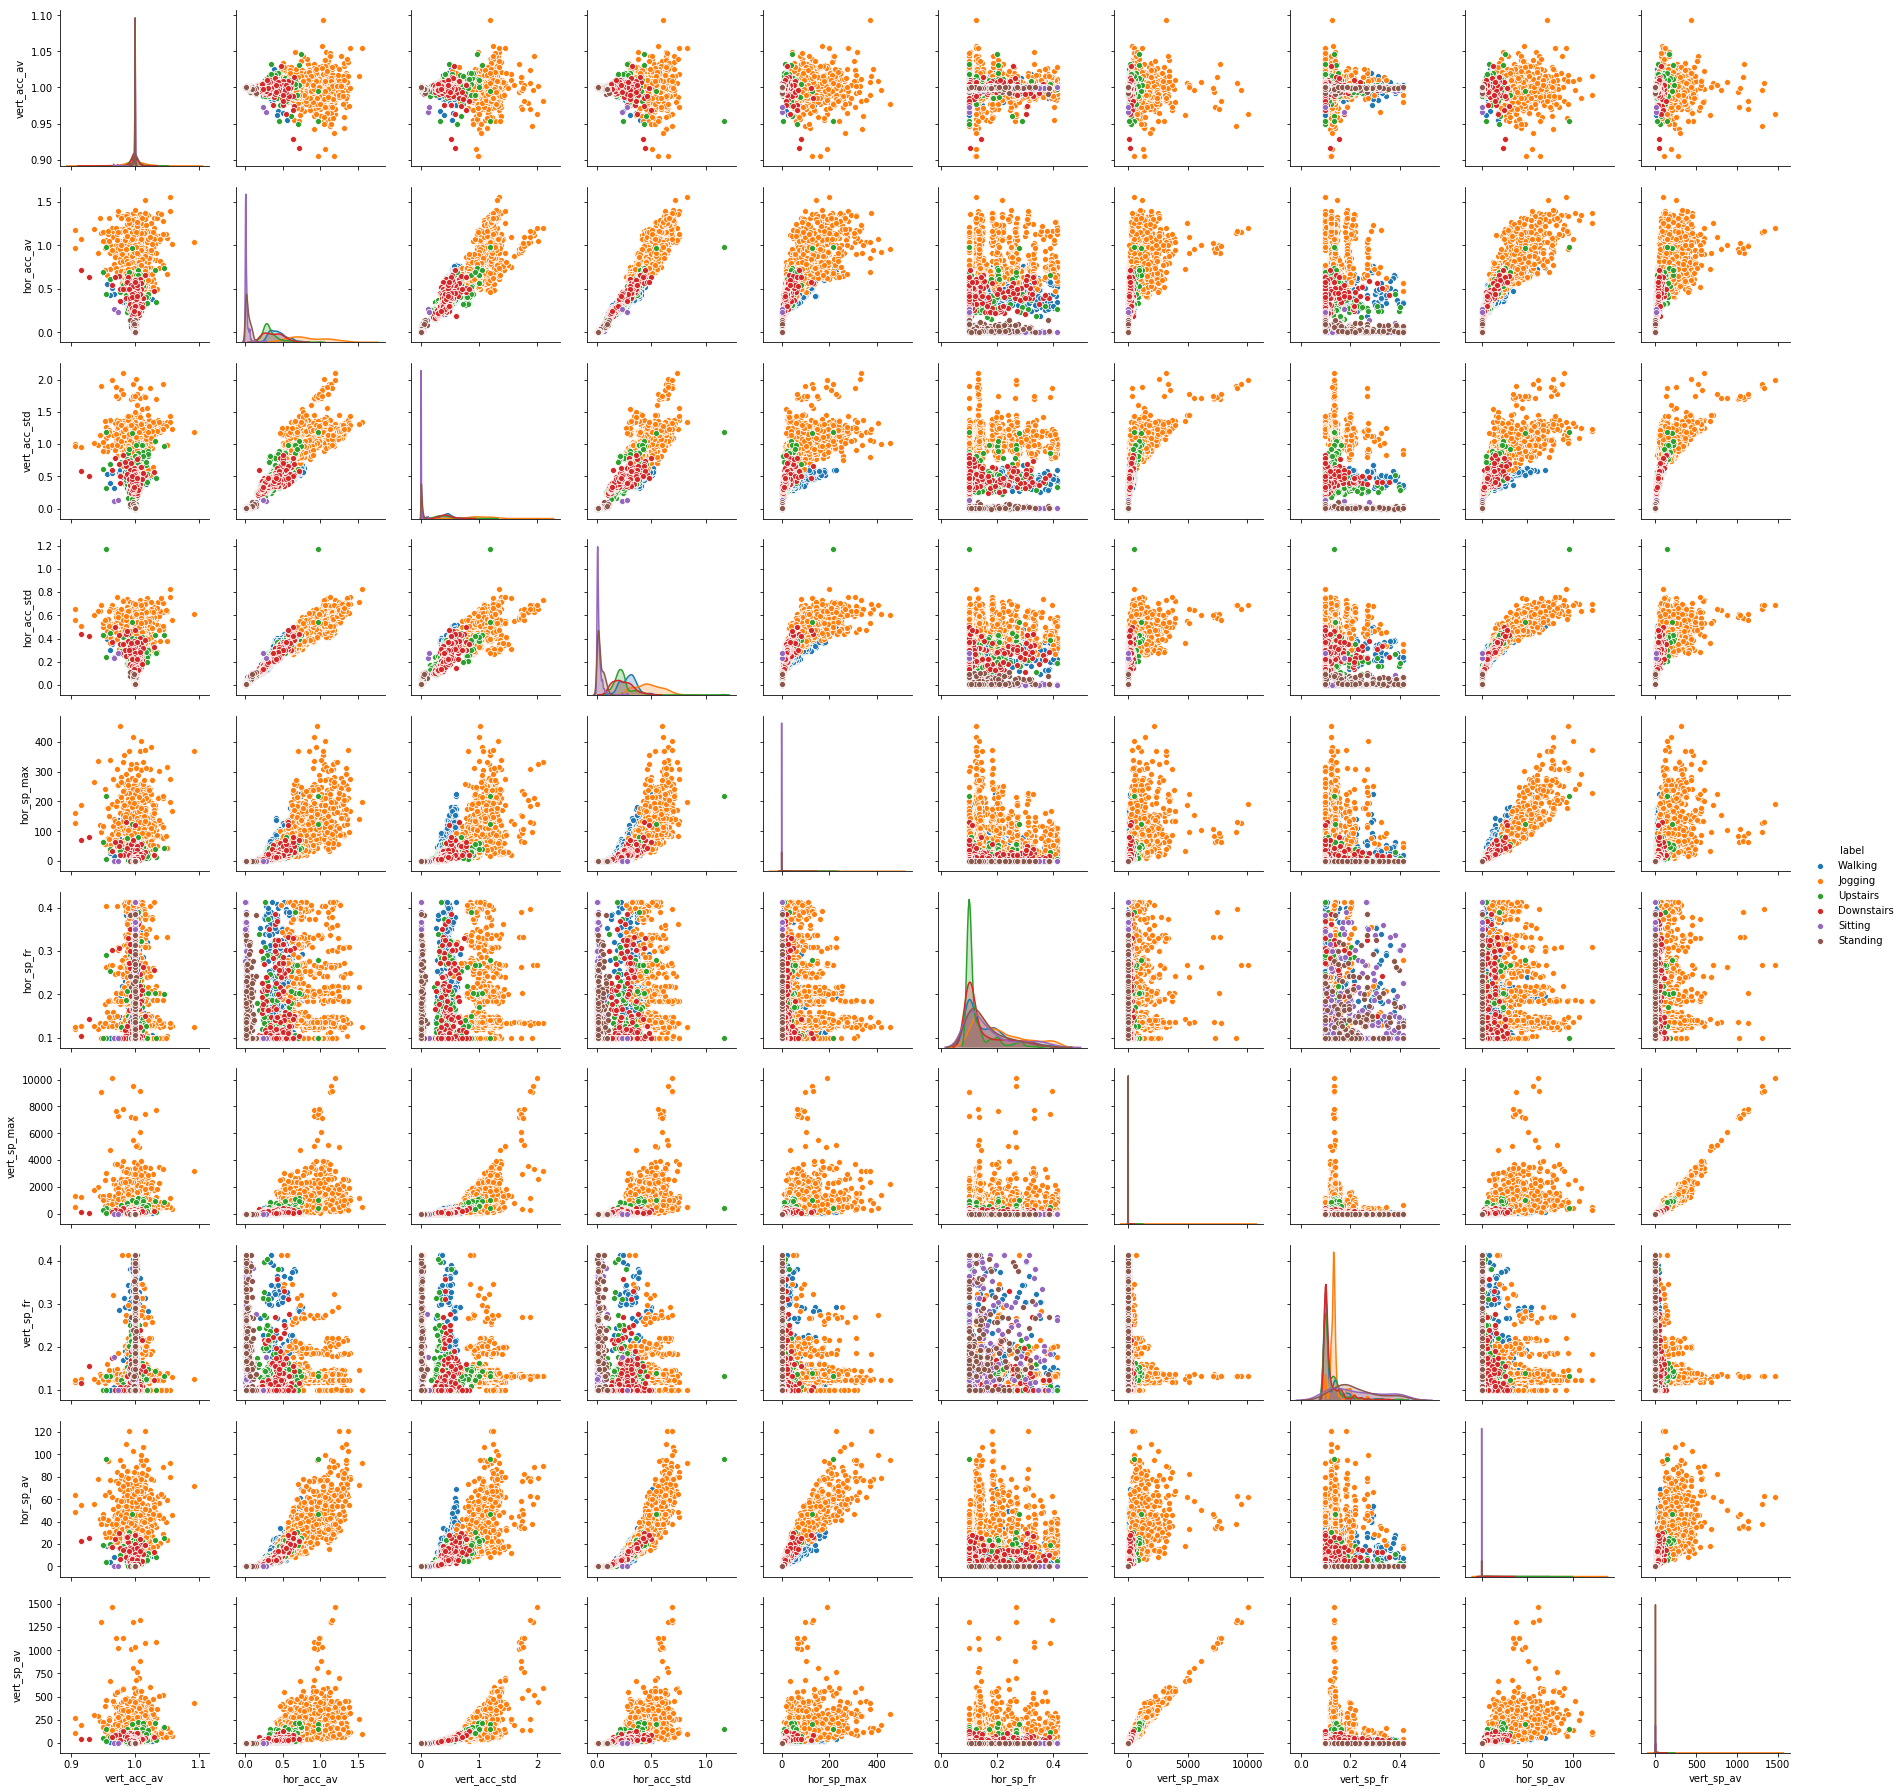

In [14]:
sns.pairplot(new_data.drop(columns = [*['hist_hor'+str(i) for i in range(hist_size)],
               *['hist_vert'+str(i) for i in range(hist_size)]]), hue='label')

plt.show()

/home/anton/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


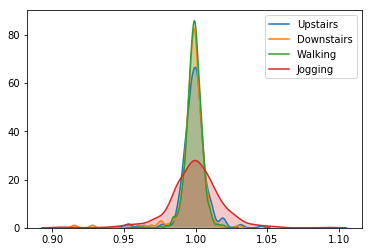

In [15]:
sns.kdeplot(new_data[new_data.label == 'Upstairs'].vert_acc_av, label='Upstairs', shade=True);
sns.kdeplot(new_data[new_data.label == 'Downstairs'].vert_acc_av, label='Downstairs', shade=True);
sns.kdeplot(new_data[new_data.label == 'Walking'].vert_acc_av, label='Walking', shade=True);
sns.kdeplot(new_data[new_data.label == 'Jogging'].vert_acc_av, label='Jogging', shade=True);
plt.show()

/home/anton/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


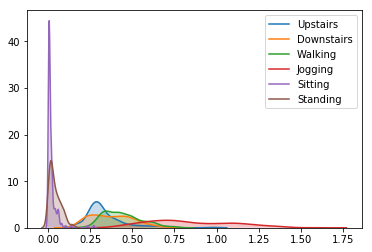

In [16]:
sns.kdeplot(new_data[new_data.label == 'Upstairs'].hor_acc_av, label='Upstairs', shade=True);
sns.kdeplot(new_data[new_data.label == 'Downstairs'].hor_acc_av, label='Downstairs', shade=True);
sns.kdeplot(new_data[new_data.label == 'Walking'].hor_acc_av, label='Walking', shade=True);
sns.kdeplot(new_data[new_data.label == 'Jogging'].hor_acc_av, label='Jogging', shade=True);
sns.kdeplot(new_data[new_data.label == 'Sitting'].hor_acc_av, label='Sitting', shade=True);
sns.kdeplot(new_data[new_data.label == 'Standing'].hor_acc_av, label='Standing', shade=True);
plt.show()

In [17]:
y = list(new_data.label.values)
for act in activities:
    print('%s: %i'%(act, y.count(act)))

Jogging: 719
Downstairs: 209
Walking: 1286
Upstairs: 285
Sitting: 178
Standing: 138


## Обучаем модели
В качестве класификатора используем логистическую регрессию со стратегией OvR

In [18]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix


In [19]:
X = new_data.drop(columns=['label'])
y = new_data.label.values
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
lr =LogisticRegression(penalty='l1', C=0.1)

In [20]:
for train_indices, test_indices in skf.split(X, y):
    lr.fit(X.values[train_indices], y[train_indices])
    print(lr.score(X.values[test_indices], y[test_indices]))

0.7946902654867256
0.7783687943262412
0.7783687943262412
0.791814946619217
0.7892857142857143


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
lr.fit(X_train, y_train)
predict = lr.predict(X_test)
print(new_data.columns)
lr.coef_[-1]

Index(['vert_acc_av', 'hor_acc_av', 'vert_acc_std', 'hor_acc_std',
       'hor_sp_max', 'hor_sp_fr', 'vert_sp_max', 'vert_sp_fr', 'hor_sp_av',
       'vert_sp_av', 'hist_hor0', 'hist_hor1', 'hist_hor2', 'hist_hor3',
       'hist_hor4', 'hist_hor5', 'hist_hor6', 'hist_hor7', 'hist_hor8',
       'hist_hor9', 'hist_hor10', 'hist_hor11', 'hist_hor12', 'hist_hor13',
       'hist_hor14', 'hist_hor15', 'hist_hor16', 'hist_hor17', 'hist_hor18',
       'hist_hor19', 'hist_vert0', 'hist_vert1', 'hist_vert2', 'hist_vert3',
       'hist_vert4', 'hist_vert5', 'hist_vert6', 'hist_vert7', 'hist_vert8',
       'hist_vert9', 'hist_vert10', 'hist_vert11', 'hist_vert12',
       'hist_vert13', 'hist_vert14', 'hist_vert15', 'hist_vert16',
       'hist_vert17', 'hist_vert18', 'hist_vert19', 'label'],
      dtype='object')


array([-8.34476412e-01,  0.00000000e+00,  0.00000000e+00,  3.49796534e+00,
        3.16637914e-02,  0.00000000e+00, -2.09142226e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.06436898e-02, -7.28014739e-02,
       -2.84198935e-02,  5.55813337e-02,  0.00000000e+00, -5.26039442e-04,
       -2.35333190e-02,  1.18953055e-02,  0.00000000e+00, -1.83697908e-02,
        0.00000000e+00, -2.06650161e-02,  5.10267444e-02,  0.00000000e+00,
       -3.86160439e-02,  1.38227355e-01,  0.00000000e+00, -1.60633996e-01,
        1.13598145e-01, -2.19564410e-02,  4.24812082e-02, -1.23252776e-02,
       -5.42946926e-02,  1.66797176e-01, -1.64562636e-01,  1.42127040e-01,
       -9.73447337e-02,  0.00000000e+00,  8.23875982e-02, -1.76727742e-01,
        3.06849881e-02,  0.00000000e+00, -5.75783872e-02,  7.55771369e-02,
       -1.06487425e-02, -5.39524355e-02,  1.35758167e-01, -3.91929502e-02,
        1.45758271e-03,  1.26677297e-02])

Normalized confusion matrix
[[0.92276423 0.00813008 0.06097561 0.00813008 0.         0.        ]
 [0.         0.26086957 0.60869565 0.13043478 0.         0.        ]
 [0.00243309 0.00729927 0.98296837 0.00729927 0.         0.        ]
 [0.06382979 0.13829787 0.61702128 0.18085106 0.         0.        ]
 [0.         0.         0.01694915 0.         0.98305085 0.        ]
 [0.         0.         0.04       0.         0.92       0.04      ]]


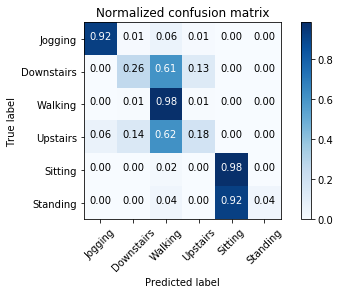

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


act = list(activities)
sorted(act)
cm = confusion_matrix(y_test, predict, labels = act)
plot_confusion_matrix(cm, classes=act, normalize=True,
                      title='Normalized confusion matrix')

In [23]:
print('Actually')
for act in activities:
    print('%s: %i'%(act, list(y_test).count(act)))

Actually
Jogging: 246
Downstairs: 69
Walking: 411
Upstairs: 94
Sitting: 59
Standing: 50


In [24]:
print(accuracy_score(y_test, predict)*100, "%")

78.14854682454252 %


Рассмотим более продвинутую модель

In [25]:
from sklearn.ensemble import RandomForestClassifier

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [26]:
X = new_data.drop(columns=['label'])
y = new_data.label.values
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
cf = RandomForestClassifier()
for train_indices, test_inactivitiesdices in skf.split(X, y):
    cf.fit(X_train, y_train)
    predict = cf.predict(X_test)
    print(accuracy_score(y_test, predict)*100, "%")

86.75995694294942 %
86.32938643702907 %
86.0064585575888 %
86.32938643702907 %
85.36060279870829 %


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
cf.fit(X_train, y_train)
predict = cf.predict(X_test)
print(accuracy_score(y_test, predict)*100, "%")

86.54467168998924 %


Normalized confusion matrix
[[0.98734177 0.         0.01265823 0.         0.         0.        ]
 [0.07246377 0.44927536 0.36231884 0.11594203 0.         0.        ]
 [0.         0.01886792 0.95990566 0.02122642 0.         0.        ]
 [0.04255319 0.11702128 0.26595745 0.57446809 0.         0.        ]
 [0.         0.         0.         0.         0.76271186 0.23728814]
 [0.         0.         0.         0.         0.2826087  0.7173913 ]]


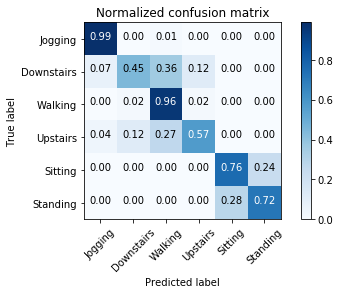

In [28]:
act = list(activities)
sorted(act)
cm = confusion_matrix(y_test, predict, labels = act)
plot_confusion_matrix(cm, classes=act, normalize=True,
                      title='Normalized confusion matrix')

строим график зависимости accuracy от доли объектов в обучающей выборке

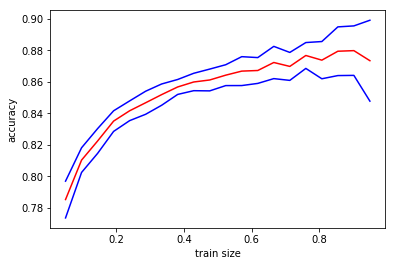

In [29]:
STEPS_PER_POINT = 31
train_sizes = np.linspace(0.05, 0.95, num=20)
vals = {x_t:[] for x_t in train_sizes}
for train_size in train_sizes:
    for i in range(STEPS_PER_POINT):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 -train_size), stratify=y)
        cf.fit(X_train, y_train)
        predict = cf.predict(X_test)
        acc = accuracy_score(y_test, predict)
        vals[train_size].append(acc)
y_av = [np.mean(vals[x_t]) for x_t in train_sizes]
#print(train_sizes)
#print(y_av)
y_std = [np.std(vals[x_t]) for x_t in train_sizes]
y_low = [y_av[i] - y_std[i] for i in range(len(vals))]
y_up = [y_av[i] + y_std[i] for i in range(len(vals))]
plt.plot(train_sizes, y_av, color= 'r')
plt.plot(train_sizes, y_low, color= 'b')
plt.plot(train_sizes, y_up, color= 'b')
plt.xlabel('train size')
plt.ylabel("accuracy")
plt.show()

ниже тот же график без стратификации

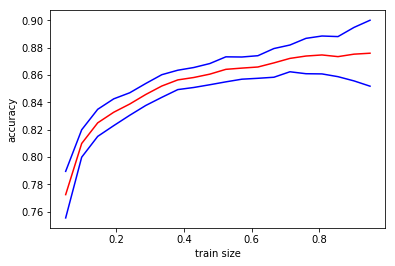

In [30]:
STEPS_PER_POINT = 31
train_sizes = np.linspace(0.05, 0.95, num=20)
vals = {x_t:[] for x_t in train_sizes}
for train_size in train_sizes:
    for i in range(STEPS_PER_POINT):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 -train_size))
        cf.fit(X_train, y_train)
        predict = cf.predict(X_test)
        acc = accuracy_score(y_test, predict)
        vals[train_size].append(acc)
y_av = [np.mean(vals[x_t]) for x_t in train_sizes]
#print(train_sizes)
#print(y_av)
y_std = [np.std(vals[x_t]) for x_t in train_sizes]
y_low = [y_av[i] - y_std[i] for i in range(len(vals))]
y_up = [y_av[i] + y_std[i] for i in range(len(vals))]
plt.plot(train_sizes, y_av, color= 'r')
plt.plot(train_sizes, y_low, color= 'b')
plt.plot(train_sizes, y_up, color= 'b')
plt.xlabel('train size')
plt.ylabel("accuracy")
plt.show()


## Выводы
Используя линейные методы для решения данной задачи, можно получить неплохой результат по метреке accuracy (70-75%), однако в этом случае менее населенные классы практически не определяются.

Использование L1 регуляризациии позволяет произвести отбор признаков, не все признаки оказались сильно информативными

Использование слкучайного леса существенно улучшает качество классификации (до 86%)

Мы хорошо предсказываем типы движения Jogging  и walking и относительно неплохо sitting и standing (допуская ошибку только внутри самих классов)

Вконце мы построили график зависимости точности классификации онт объемов обучающей выборки, как видно, с увеличением точность растет
